In [1]:
import tensorflow as tf
import keras

print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

2024-06-12 06:21:24.965994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 06:21:24.966141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 06:21:25.084139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version: 2.15.0
Keras version: 3.3.3


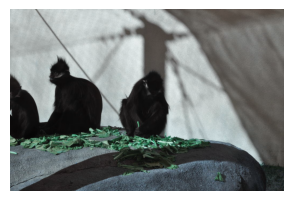

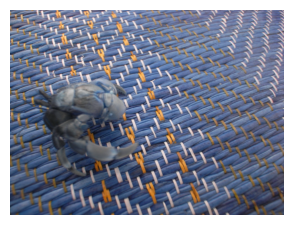

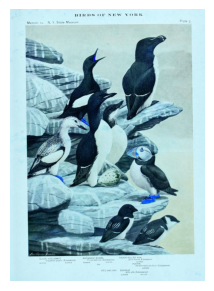

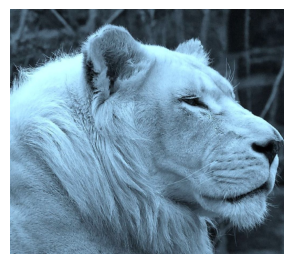

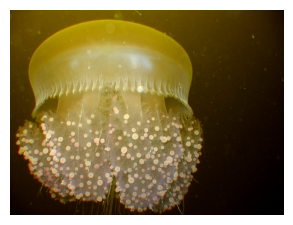

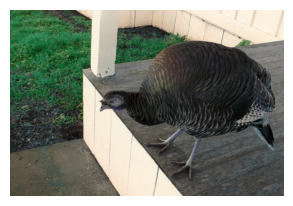

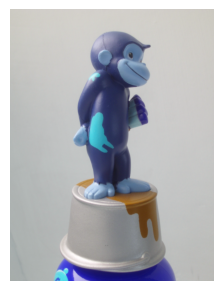

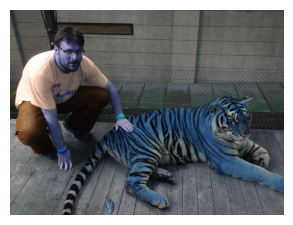

In [2]:
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2

images = glob("/kaggle/input/animals-detection-images-dataset/train/**/**")
for i in range (8):
    Image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(Image))
    plt.axis('off')

## Preparing Data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  
    rotation_range=20   
)
train_generator = datagen_train.flow_from_directory("/kaggle/input/animals-detection-images-dataset/train",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode= "categorical",
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(rescale=1./255)
validation_generator = datagen_train.flow_from_directory("/kaggle/input/animals-detection-images-dataset/test",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode= "categorical",
                                                    shuffle=True)


Found 22566 images belonging to 80 classes.
Found 6505 images belonging to 80 classes.


In [4]:
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv2D, Activation, MaxPooling2D

def Convolution(input_tensor, filter, kernel_size):
    x = Conv2D(filters=filter, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    return x


In [5]:
from tensorflow.keras.layers import Dense, Dropout


def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [6]:
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.models import Model

def model_fer(inputs):
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1 ,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten,256)

    output = Dense(80,activation= "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])  # Use 'inputs' instead of 'input'
    
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])

    return model

In [7]:
input_shape = (48,48,1)
input_layer = Input(shape=input_shape)
model = model_fer(input_layer)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │        20,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,327,824 (5.07 MB)

 Trainable params: 1,326,864 (5.06 MB)

 Non-trainable params: 960 (3.75 KB)

## Initiating the Model

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.keras", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

# Add it to your callbacks
callbacks = [checkpoint, early_stopping]

In [9]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [10]:
from tensorflow.keras.optimizers import Adam

# Define your learning rate
learning_rate = 0.001

# Create your optimizer
optimizer = Adam(learning_rate=learning_rate)

# Compile your model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

## Training the Model

In [11]:
history = model.fit(
    x = train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-12 06:22:09.919972: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.16473, expected 0.928603
2024-06-12 06:22:09.920035: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 1.1794, expected 0.943274
2024-06-12 06:22:09.920046: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 0.892153, expected 0.656024
2024-06-12 06:22:09.920056: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 1.163, expected 0.926874
2024-06-12 06:22:09.920063: E external/local_xla/xla/service/gpu/buffer_comparator.cc

  1/352 ━━━━━━━━━━━━━━━━━━━━ 2:01:39 21s/step - accuracy: 0.0000e+00 - f1_score: 0.0000e+00 - loss: 4.9971

I0000 00:00:1718173335.609959     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718173335.631412     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/352 ━━━━━━━━━━━━━━━━━━━━ 4:38 958ms/step - accuracy: 0.0592 - f1_score: 0.0032 - loss: 4.4064

2024-06-12 06:23:17.065980: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2304: 1.92404, expected 1.07332
2024-06-12 06:23:17.066043: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2305: 3.09736, expected 2.24665
2024-06-12 06:23:17.066053: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2306: 3.06036, expected 2.20965
2024-06-12 06:23:17.066061: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2307: 2.95108, expected 2.10037
2024-06-12 06:23:17.066069: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2308: 3.2397, expected 2.38899
2024-06-12 06:23:17.066077: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2309: 2.9419, expected 2.09119
2024-06-12 06:23:17.066084: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2310: 2.63817, expected 1.78746
2024-06-12 06:23:17.066092: E extern

346/352 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.0848 - f1_score: 0.0060 - loss: 4.0760

W0000 00:00:1718173687.636000     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.03419, saving model to model.weights.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 471s 1s/step - accuracy: 0.0851 - f1_score: 0.0061 - loss: 4.0724 - val_accuracy: 0.0342 - val_f1_score: 3.0465e-04 - val_loss: 5.3119
Epoch 2/15
  1/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1250 - f1_score: 0.0299 - loss: 3.6498

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-12 06:29:47.005023: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2304: 2.16946, expected 1.31974
2024-06-12 06:29:47.005081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2305: 2.44698, expected 1.59726
2024-06-12 06:29:47.005096: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2306: 2.91589, expected 2.06616
2024-06-12 06:29:47.005109: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2307: 2.82089, expected 1.97116
2024-06-12 06:29:47.005119: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2308: 2.74751, expect


Epoch 2: val_accuracy improved from 0.03419 to 0.07317, saving model to model.weights.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1250 - f1_score: 0.0299 - loss: 3.6498 - val_accuracy: 0.0732 - val_f1_score: 0.0000e+00 - val_loss: 4.9261
Epoch 3/15
346/352 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - accuracy: 0.1310 - f1_score: 0.0167 - loss: 3.6816
Epoch 3: val_accuracy improved from 0.07317 to 0.09097, saving model to model.weights.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 251s 703ms/step - accuracy: 0.1311 - f1_score: 0.0168 - loss: 3.6809 - val_accuracy: 0.0910 - val_f1_score: 0.0069 - val_loss: 4.0385
Epoch 4/15
  1/352 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1562 - f1_score: 0.0000e+00 - loss: 3.5019
Epoch 4: val_accuracy did not improve from 0.09097
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.1562 - f1_score: 0.0000e+00 - loss: 3.5019 - val_accuracy: 0.0488 - val_f1_score: 0.0000e+00 - val_loss: 4.1648
Epoch 5/15
346/352 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step

In [12]:
model.evaluate(validation_generator)

102/102 ━━━━━━━━━━━━━━━━━━━━ 58s 565ms/step - accuracy: 0.0992 - f1_score: 0.0024 - loss: 4.1709


[4.186990261077881, 0.09454265981912613, 0.002696649171411991]

## PLotting Loss

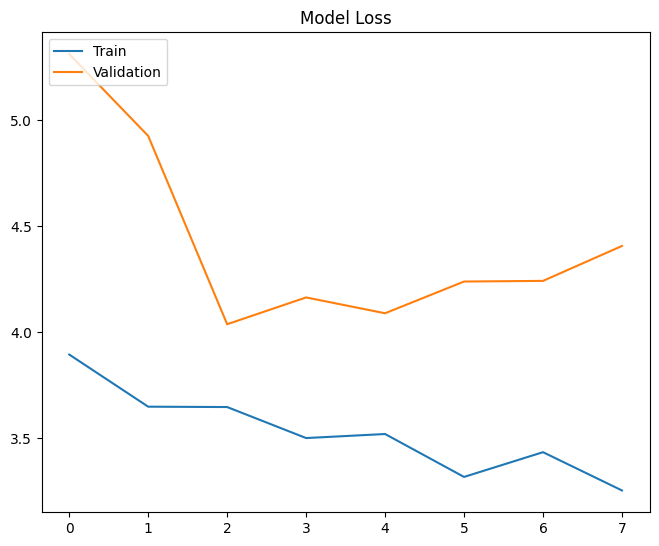

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

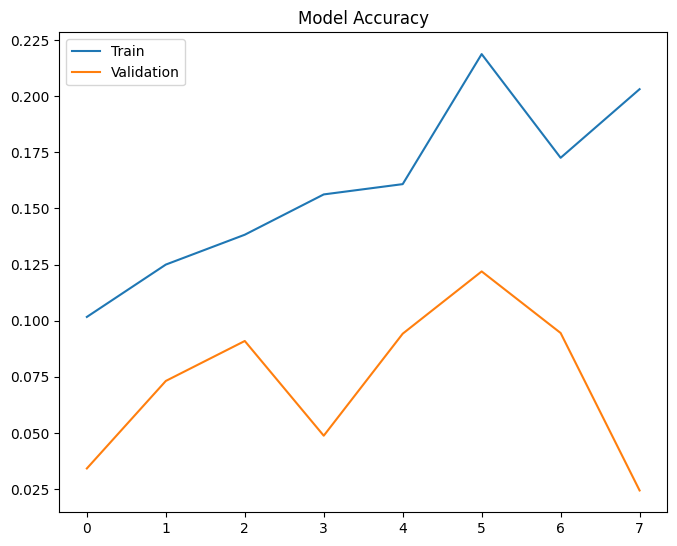

In [14]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

## Model Saving

In [15]:
model_json = model.to_json()
with open("Trained_model_kaggle.json","w") as json_file:
    json_file.write(model_json)